# Quenching and drifting examples
In this notebook we apply the quenching and drifting stages to a track dataset

In [ ]:
# This is need so you can import larndsim without doing python setup.py install
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
from larndsim import consts
consts.load_detector_properties("../larndsim/detector_properties/singlecube.yaml","../larndsim/pixel_layouts/layout-singlecube.yaml")

from larndsim import quenching, drifting
import importlib
importlib.reload(drifting)
importlib.reload(quenching)

from math import ceil

import matplotlib.pyplot as plt

import numpy as np
import h5py

In [3]:
with h5py.File('edepsim_1M.h5', 'r') as f:
    tracks = np.array(f['segments'])

y_start = np.copy(tracks['y_start'] )
y_end = np.copy(tracks['y_end'])
y = np.copy(tracks['y'])

tracks['y_start'] = np.copy(tracks['z_start'])
tracks['y_end'] = np.copy(tracks['z_end'])
tracks['y'] = np.copy(tracks['z'])

tracks['z_start'] = y_start
tracks['z_end'] = y_end
tracks['z'] = y

tracks = tracks[:1000]

In [4]:
tracks_box = np.copy(tracks)
tracks_birks = np.copy(tracks)

In [5]:
threadsperblock = 256
blockspergrid = ceil(tracks.shape[0] / threadsperblock)

quenching.quench[blockspergrid,threadsperblock](tracks_box, consts.box)
quenching.quench[blockspergrid,threadsperblock](tracks_birks, consts.birks)

## Recombination

The number of ionized electrons must be corrected by the recombination effect. Two models have been implemented:

- Birks (Amoruso et al. NIM A 523 (2004) 275)
\begin{equation}
R_{Birks} = \frac{A_b}{1+k_b/\epsilon\cdot dE/dx }
\end{equation}

- Modified box (Baller, 2013 JINST 8 P08005)
\begin{equation}
R_{box} = \frac{\log(\alpha + \beta \frac{dE/dx}{E\rho})}{\beta/\epsilon\cdot dE/dx}
\end{equation}

where $\epsilon=E\rho_{\mathrm{LAr}}$.

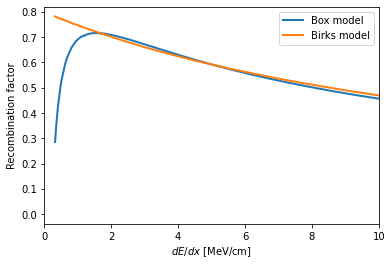

In [6]:
fig, ax = plt.subplots(1, 1)

recomb_birks = tracks_birks["n_electrons"] / (consts.MeVToElectrons * tracks_birks["dE"])
recomb_box = tracks_box["n_electrons"] / (consts.MeVToElectrons * tracks_box["dE"])

ax.plot(np.sort(tracks_box["dEdx"]), recomb_box[np.argsort(tracks_box["dEdx"])], label="Box model", lw=2)
ax.plot(np.sort(tracks_birks["dEdx"]), recomb_birks[np.argsort(tracks_birks["dEdx"])], label="Birks model", lw=2)
ax.set_xlabel("$dE/dx$ [MeV/cm]")
ax.set_ylabel("Recombination factor")
ax.set_xlim(0,10)
_ = ax.legend()

In [7]:
tracks_quenched = np.copy(tracks)
quenching.quench[blockspergrid,threadsperblock](tracks_quenched, consts.box)
tracks_drifted = np.copy(tracks_quenched)
drifting.drift[blockspergrid,threadsperblock](tracks_drifted)

## Electron lifetime
The electrons traveling towards the anode are absorbed by impurities present in the liquid argon. The decrease follows an exponential curve $N_e^{\mathrm{anode}}/N_e=\exp(-t_{\mathrm{drift}}/e_{\mathrm{lifetime}})$.

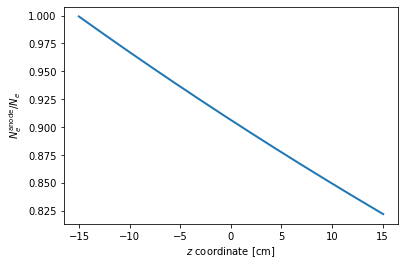

In [8]:
fig, ax = plt.subplots(1, 1)
drift_time = abs(tracks_quenched["z"] - consts.module_borders[0][2][0])/consts.vdrift
ax.plot(np.sort(tracks_quenched["z"]), np.exp(-drift_time / consts.lifetime)[np.argsort(tracks_quenched['z'])], lw=2)
ax.set_ylabel("$N_{e}^{\mathrm{anode}}/N_{e}$")
_ = ax.set_xlabel("$z$ coordinate [cm]")

## Diffusion
The diffusion coefficients (longitudinal and transverse) are proportional to $\sqrt{2t_{\mathrm{drift}}}$ (which in turn is given by $(z_{\mathrm{start}} - z_{\mathrm{anode}})/v_{\mathrm{drift}}$).

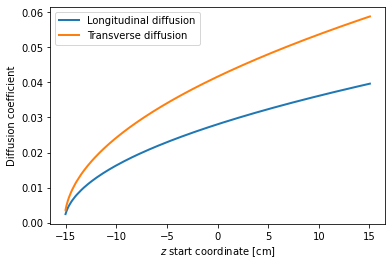

In [9]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.sort(tracks_quenched["z"]), tracks_drifted["long_diff"][np.argsort(tracks_quenched["z"])], label="Longitudinal diffusion", lw=2)
ax.plot(np.sort(tracks_quenched["z"]), tracks_drifted["tran_diff"][np.argsort(tracks_quenched["z"])], label="Transverse diffusion", lw=2)
ax.set_xlabel("$z$ start coordinate [cm]")
ax.set_ylabel("Diffusion coefficient")
_ = ax.legend()